## Imports

In [1]:
import os
import sys
import pathlib
import warnings
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import seaborn as sns

import copy
import gymnasium as gym
import pickle
import mujoco

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from llmicl.interfaces import trainers

from scipy.stats import uniform, kstwobign
from scipy.special import kolmogorov
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline

2024-09-20 17:45:11.522971: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-20 17:45:11.539206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-20 17:45:11.558360: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-20 17:45:11.564158: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-20 17:45:11.579426: I tensorflow/core/platform/cpu_feature_guar

## states and actions names

In [2]:
state_names = {
    "HalfCheetah": [
        "rootx",
        "rootz",
        "rooty",
        "bthigh",
        "bshin",
        "bfoot",
        "fthigh",
        "fshin",
        "ffoot",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "bthigh_dot",
        "bshin_dot",
        "bfoot_dot",
        "fthigh_dot",
        "fshin_dot",
        "ffoot_dot",
    ],
    "Hopper": [
        "rootx",
        "rootz",
        "rooty",
        "thigh",
        "leg",
        "foot",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "thigh_dot",
        "leg_dot",
        "foot_dot",
    ]
}
action_names = {
    "HalfCheetah": [
        "t_bthigh",
        "t_bshin",
        "t_bfoot",
        "t_fthigh",
        "t_fshin",
        "t_ffoot",
    ],
    "Hopper": [
        "thigh_joint",
        "leg_joint",
        "foot_joint",
    ]
}

# Helpers

## load model and tokenizer

In [3]:
import torch
from transformers import (
    LlamaForCausalLM, 
    AutoTokenizer
)

tokenizer = AutoTokenizer.from_pretrained(
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    use_fast=False,
)
print(f"finish loading tokenizer")
model = LlamaForCausalLM.from_pretrained(
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    device_map="auto",   
    torch_dtype=torch.bfloat16, 
)
print(f"finish loading model")
model.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


finish loading tokenizer


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

finish loading model


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head)

## policy classes

In [4]:
LOG_STD_MAX = 2
LOG_STD_MIN = -5

class Actor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.single_observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, np.prod(env.single_action_space.shape))
        self.fc_logstd = nn.Linear(256, np.prod(env.single_action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale", torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float32)
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (log_std + 1)  # From SpinUp / Denis Yarats

        return mean, log_std

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean, std

def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        else:
            env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env.action_space.seed(seed)
        return env
    return thunk

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class PPOAgent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        self.critic = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )
        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, np.prod(envs.single_action_space.shape)), std=0.01),
        )
        self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(envs.single_action_space.shape)))

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        action_mean = self.actor_mean(x)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        if action is None:
            action = probs.sample()
        return (
            action,
            probs.log_prob(action).sum(1),
            probs.entropy().sum(1),
            self.critic(x),
            action_mean,
            action_std
        )

class TD3Actor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.single_observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mu = nn.Linear(256, np.prod(env.single_action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale", torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float32)
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc_mu(x))
        return x * self.action_scale + self.action_bias

## mujoco set and get state

In [5]:
# Extract the state from the MuJoCo model and data
def get_mujoco_state(env):
    model = env.unwrapped.model
    data = env.unwrapped.data
    state = {
        'qpos': data.qpos.copy(),
        'qvel': data.qvel.copy(),
        'act': data.act.copy(),
        'ctrl': data.ctrl.copy(),
        'mocap_pos': data.mocap_pos.copy(),
        'mocap_quat': data.mocap_quat.copy(),
        'userdata': data.userdata.copy(),
        'time': data.time,
    }
    return state

# Set the state back into the MuJoCo model and data
def set_mujoco_state(env, state):
    data = env.unwrapped.data
    data.qpos[:] = state['qpos']
    data.qvel[:] = state['qvel']
    data.act[:] = state['act']
    data.ctrl[:] = state['ctrl']
    data.mocap_pos[:] = state['mocap_pos']
    data.mocap_quat[:] = state['mocap_quat']
    data.userdata[:] = state['userdata']
    data.time = state['time']
    mujoco.mj_forward(env.unwrapped.model, data)

# Main loop

## helper fn

In [27]:
def rollout(max_episode_length=1000, context_length=400, init_index=0):
    obs_next, _ = env.reset()
    restart = True
    df_lines = []
    episode_states = []
    track_entropy = 0.0
    for step in range(max_episode_length):
        obs = obs_next
        line = []
        line.append(obs[None, ...])
        if 'sac' in policy_path:
            action, _, action_mean, std = actor.get_action(
                torch.Tensor(obs[None, ...]).to(device)
            )
            entropy = 0.5 + 0.5 * torch.log(2 * torch.tensor(np.pi)) + std.log()
        elif ('td3' in policy_path) or ('ddpg' in policy_path):
            action = actor(torch.Tensor(obs[None, ...]).to(device))
            action += torch.normal(0, actor.action_scale * 0.1)
            entropy = 0.5 + 0.5 * torch.log(2 * torch.tensor(np.pi)) + (actor.action_scale * 0.1).log()
        elif 'ppo' in policy_path:
            action, _, entropy, _, action_mean, _ = actor.get_action_and_value(
                torch.Tensor(obs[None, ...]).to(device)
            )
        track_entropy += float(entropy.detach().cpu().numpy().mean())
        action = action.detach().cpu().numpy().flatten()
        line.append(action[None, ...])
        env_state = get_mujoco_state(env)
        obs_next, reward, terminated, truncated, _ = env.step(action)
        line.append(np.array([reward])[None, ...])
        line.append(np.array([int(restart)])[None, ...])
        line = np.concatenate(line, axis=1)
        df_lines.append(line)
        restart = False
        episode_states.append((obs_next, get_mujoco_state(env)))
        if terminated or truncated:
            break
    track_entropy /= max_episode_length
    
    assert len(df_lines) > context_length, "Error"
    
    data = np.concatenate(df_lines, axis=0)
    
    time_series = data[
        init_index : init_index + context_length, :n_observations
    ]

    return time_series, data, track_entropy

def icl(model, tokenizer, time_series, context_length, n_observations, n_actions, rescale_factor = 7.0, up_shift = 1.5):
    trainer = trainers.RLICLTrainer(
        model=model,
        tokenizer=tokenizer,
        n_observations=n_observations,
        n_actions=n_actions,
        rescale_factor=rescale_factor,
        up_shift=up_shift,
    )
    
    trainer.update_context(
        time_series=copy.copy(time_series),
        mean_series=copy.copy(time_series),
        sigma_series=np.zeros_like(time_series),
        context_length=context_length,
        update_min_max=True,
    )
    
    trainer.icl(verbose=0, stochastic=True)
    
    return trainer.compute_statistics()

def compute_metrics(data, icl_object, n_traces, n_observations, init_index=0, rescale_factor = 7.0, up_shift = 1.5):
    """
    Computes the KS metric for a given model and test dataset.

    Parameters:
    - X_test: DataFrame containing ground truth values.
    - model: A model that predicts a categorical distribution over a discretization of the ground truth variable.
    - target_column_names: List of target column names in X_test.
    - n_traces: Number of traces (samples) to generate for each prediction.
    - future_length: Number of future time steps to predict.

    Returns:
    - kss: Array containing the KS metrics for each target and horizon.
    """

    # shape of predictions: observations.reshape(n_samples, n_traces)
    # shape of groundtruth: (n_samples,) or (n_samples, 1)
    n_samples = len(icl_object[0].PDF_list)

    kss = np.zeros((n_observations,))
    r2s = np.zeros((n_observations,))
    mses = np.zeros((n_observations,))
    ks_quantiles = np.zeros((n_observations, n_samples))
    for dim in range(n_observations):
        predictions = np.empty((n_samples, n_traces))
        for t in range(n_samples):      
            PDF = icl_object[dim].PDF_list[t]
            
            ts_min = icl_object[dim].rescaling_min
            ts_max = icl_object[dim].rescaling_max
            
            bin_center_arr = ((PDF.bin_center_arr - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
            bin_height_arr = PDF.bin_height_arr / np.sum(PDF.bin_height_arr)

            samples = np.random.choice(
                bin_center_arr,
                p=PDF.bin_height_arr / np.sum(PDF.bin_height_arr),
                size=(n_traces,)
            )

            predictions[t, :] = copy.copy(samples)

        groundtruth = data[init_index+1:init_index+context_length+1, dim].flatten()

        # Compute quantiles
        quantiles = np.sort(np.array([g > m for g, m in zip(groundtruth, predictions)]).sum(axis=1))
        quantiles = quantiles / n_traces

        # Compute KS metric
        kss[dim] = np.max(np.abs(quantiles - (np.arange(len(quantiles)) / len(quantiles))))
        ks_quantiles[dim, :] = quantiles

        # r2
        mean_predictions = predictions.mean(axis=1)
        r2s[dim] = r2_score(groundtruth, mean_predictions)
        mses[dim] = mean_squared_error(groundtruth, mean_predictions)

    return kss, ks_quantiles, r2s, mses

## main

In [28]:
env_name = "HalfCheetah"
env = gym.make(env_name)
n_actions = env.action_space.shape[0]
n_observations = env.observation_space.shape[0]
context_length = 400
n_traces = 100
algos = ['sac', 'td3', 'ppo',] # 'ddpg']
policy_path_dict = {
    'sac': "/home/abenechehab/cleanrl/runs/HalfCheetah-v4__sac_continuous_action__1__1723208574",
    'td3': "/home/abenechehab/cleanrl/runs/HalfCheetah-v4__td3__1__1723562307",
    'ppo': "/home/abenechehab/cleanrl/runs/HalfCheetah-v4__ppo_checkpoints__7__1724072335",
    # 'ddpg': "/home/abenechehab/cleanrl/runs/HalfCheetah-v4__ddpg__1__1723553922",
}
policy_checkpoint_list = [10000, 20000, 30000, 50000, 100000, 200000, 300000, 400000, 500000, 750000, 850000, 990000]
columns = ['dim', 'algo', 'policy', 'entropy', 'state_coverage', 'ks', 'r2', 'mse']

/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `HalfCheetah-v4` instead of the unversioned environment `HalfCheetah`.
  logger.warn(


In [ ]:
df = pd.DataFrame(columns=columns)
for algorithm in tqdm(algos, desc='algo'):
    for policy_checkpoint in tqdm(policy_checkpoint_list, desc='policy'):
        policy_path = policy_path_dict[algorithm]
        # load actor
        envs = gym.vector.SyncVectorEnv([make_env(env_name, seed=7, idx=0, capture_video=False, run_name="")])
        if algorithm=='sac':
            actor = Actor(envs).to(device)
            actor.load_state_dict(torch.load(f"{policy_path}/actor_checkpoint_{policy_checkpoint}.pth"))
        elif (algorithm=='td3') or (algorithm=='ddpg'):
            actor = TD3Actor(envs).to(device)
            actor.load_state_dict(torch.load(f"{policy_path}/actor_checkpoint_{policy_checkpoint}.pth"))
        else:
            actor = PPOAgent(envs).to(device)
            actor.load_state_dict(torch.load(f"{policy_path}/agent_checkpoint_{policy_checkpoint}.pth"))
        actor.eval()

        time_series, data, entropy = rollout(max_episode_length = 1000, context_length = 400)

        # standard scaling
        scaling_pipeline = make_pipeline(MinMaxScaler(), StandardScaler())
        scaling_pipeline.fit(data[:, :n_observations])
        time_series = scaling_pipeline.transform(time_series)

        icl_object = icl(
            model=model, 
            tokenizer=tokenizer, 
            time_series=time_series, 
            context_length=context_length, 
            n_observations=n_observations, 
            n_actions=n_actions, 
            rescale_factor=7.0, 
            up_shift=1.5
        )

        kss, ks_quantiles, r2s, mses = compute_metrics(scaling_pipeline.transform(data[:, :n_observations]), icl_object, n_traces, n_observations)

        for dim in range(n_observations):
            df = pd.concat([df, pd.DataFrame(
                [[
                    state_names[env_name][dim], 
                    algorithm, 
                    policy_checkpoint, 
                    entropy, 
                    float(time_series[:,dim].max()-time_series[:,dim].min()), 
                    kss[dim], 
                    r2s[dim],
                    mses[dim],
                ]],
                columns=columns
            )], axis=0)
df.to_csv('/mnt/vdb/abenechehab/entropy_state_cov_corr_scaled.csv')
df.head()

policy:   0%|                                                                                                     | 0/12 [00:00<?, ?it/s]/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `HalfCheetah-v4` instead of the unversioned environment `HalfCheetah`.
  logger.warn(
/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py:500: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr

policy:   8%|███████▊                        

In [3]:
df = pd.read_csv('/mnt/vdb/abenechehab/entropy_state_cov_corr_scaled.csv')

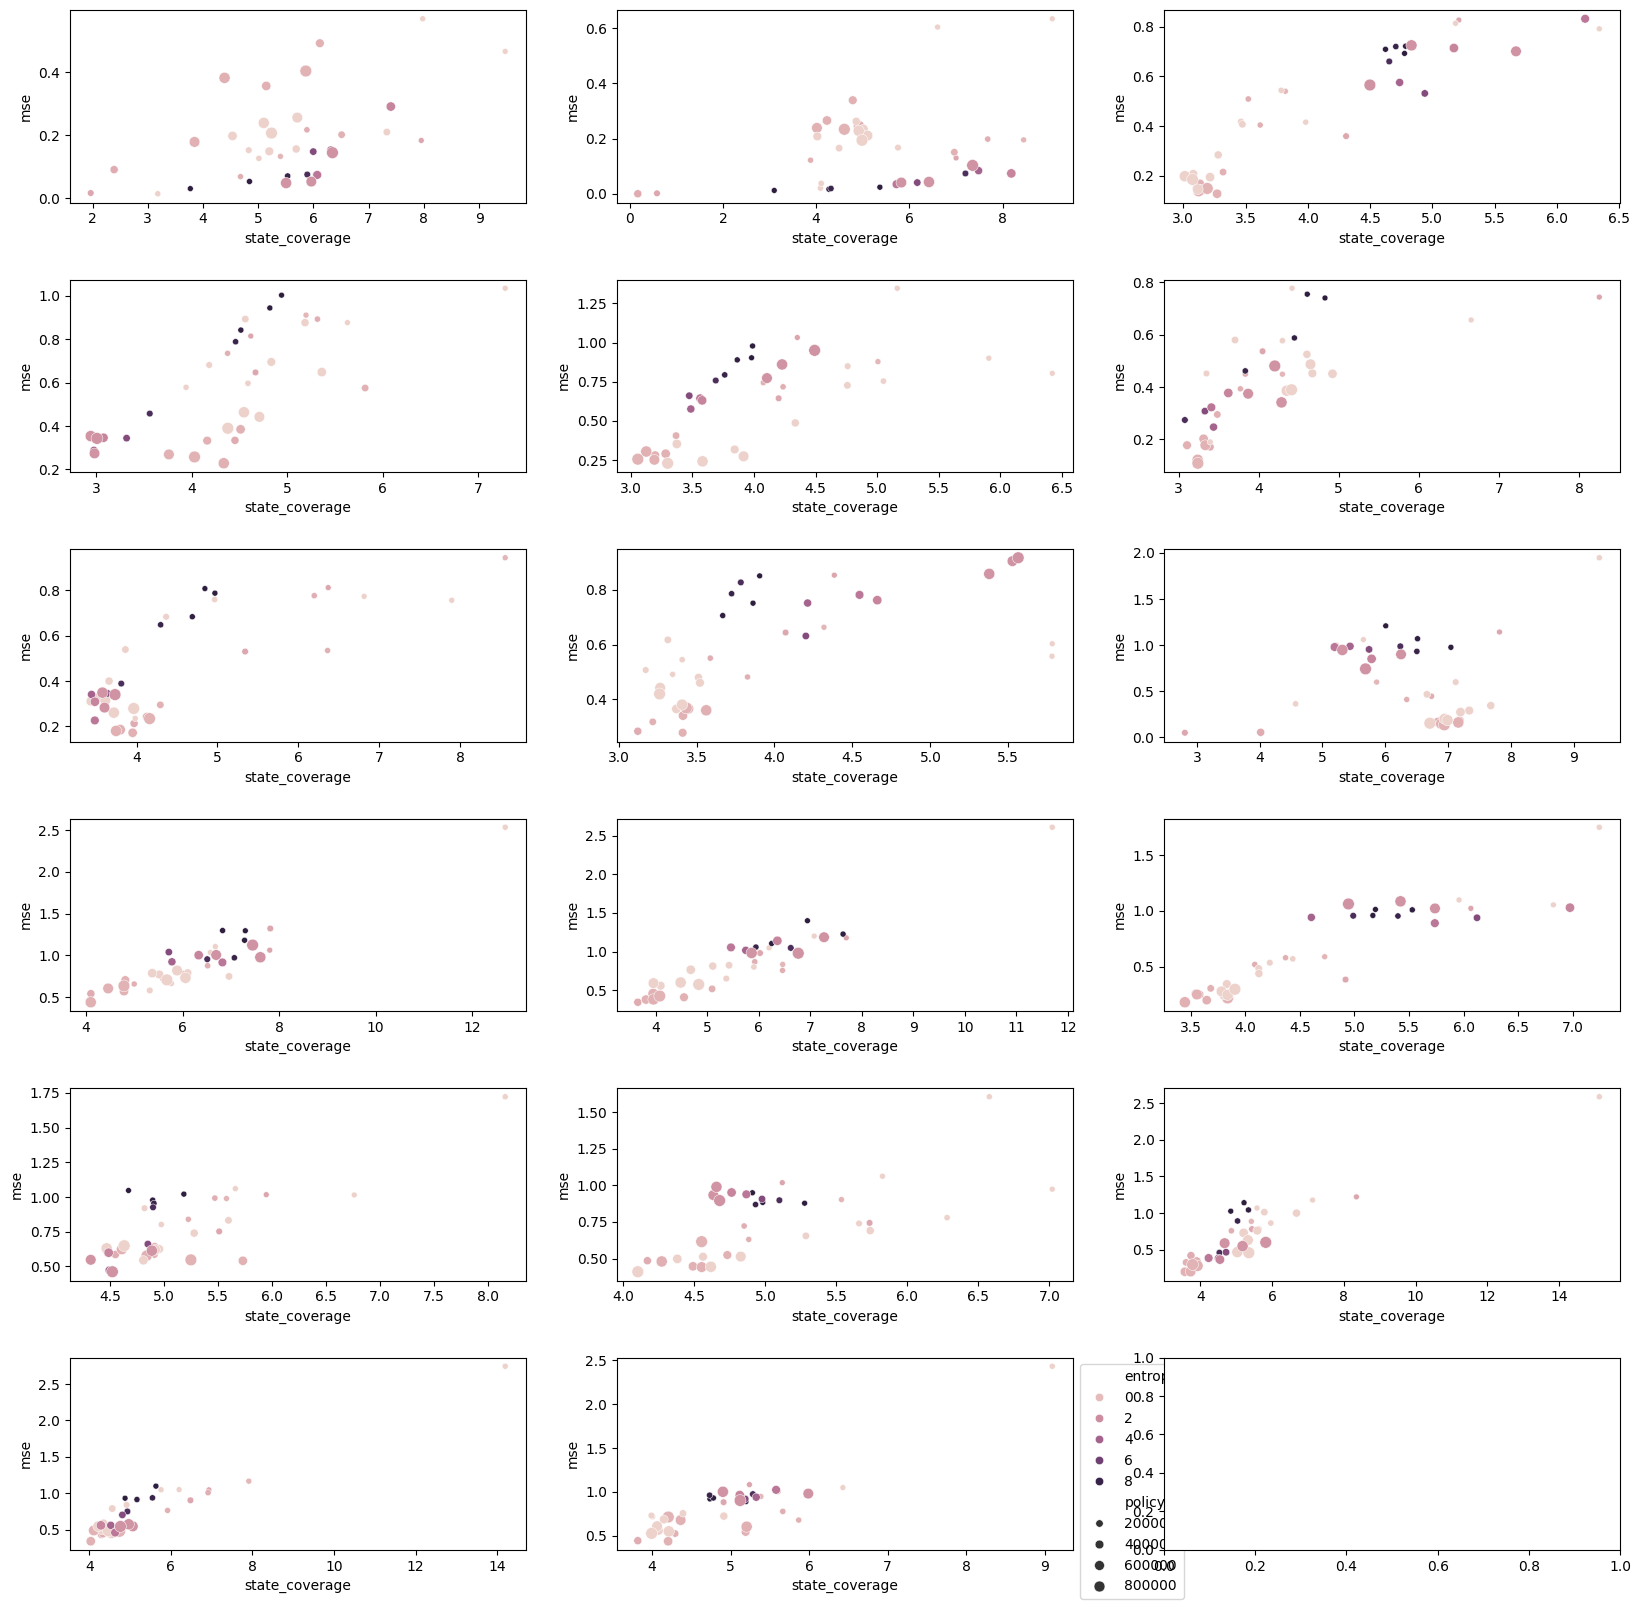

In [31]:
f, axes = plt.subplots(6, 3, figsize=(20, 20), gridspec_kw={'wspace':0.2, 'hspace':0.4})
axes = list(np.array(axes).flatten())
for dim in range(n_observations):
    sns.scatterplot(
        data=df[df['dim']==state_names[env_name][dim]], 
        x='state_coverage', 
        y='mse', 
        hue='entropy', 
        size='policy',
        ax=axes[dim],
        legend=None if dim<n_observations-1 else True
    )
sns.move_legend(axes[dim], "upper left", bbox_to_anchor=(1, 1))
plt.show()

/tmp/ipykernel_1516183/194238921.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ax = sns.scatterplot(data=df.groupby(['algo', 'policy']).mean(), x='state_coverage', y='r2', hue='policy', style='algo')


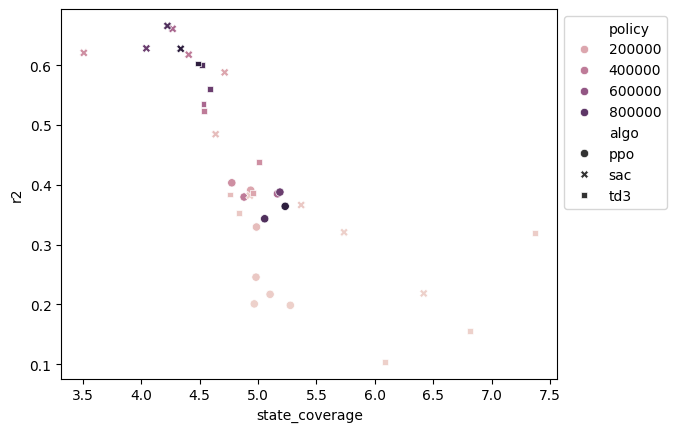

In [32]:
ax = sns.scatterplot(data=df.groupby(['algo', 'policy']).mean(), x='state_coverage', y='r2', hue='policy', style='algo')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

/tmp/ipykernel_1664986/1901710900.py:47: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data=df.groupby(['algo', 'policy']).mean().reset_index(),
/tmp/ipykernel_1664986/1901710900.py:61: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data=df.groupby(['algo', 'policy']).mean().reset_index(),
/tmp/ipykernel_1664986/1901710900.py:76: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data=df.groupby(['algo', 'policy']).mean().r

<Figure size 640x480 with 0 Axes>

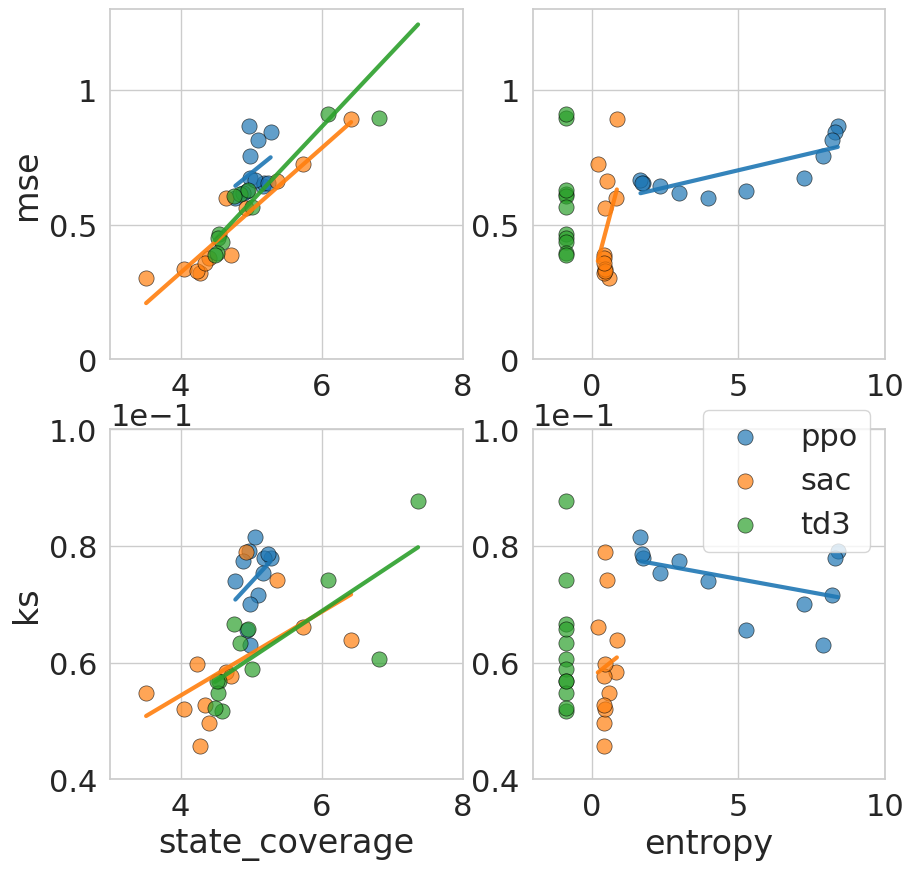

In [34]:
from matplotlib.ticker import FormatStrFormatter

def hue_regplot(data, x, y, hue, palette=None, colormap=None, **kwargs):
    from matplotlib.pyplot import get_cmap
    
    regplots = []
    
    levels = data[hue].unique()
    
    if palette is None:
        if colormap is None:
            default_colors = get_cmap('tab10')
        else:
            default_colors = get_cmap(colormap)
        palette = {k: default_colors(i) for i, k in enumerate(levels)}
    
    for key in levels:
        regplots.append(
            sns.regplot(
                x=x,
                y=y,
                data=data[data[hue] == key],
                color=palette[key],
                label=key,
                scatter_kws={'s': 120, 'edgecolors': 'black', 'linewidths': 0.5, 'alpha': 0.7},  # Thin black border on dots
                line_kws={'linewidth': 3, 'alpha': 0.9},
                **kwargs
            )
        )
    
    return regplots

sns.set_theme(style="whitegrid", font_scale=2)
sns.set_palette("colorblind")
sns.despine()
# sns.set(font_scale=2, style=)

# plt.rcParams["figure.figsize"] = [10, 10]
# plt.rcParams["figure.autolayout"] = True

plt.figure(figsize=(10,10))

ax1 = plt.subplot(2, 2, 1)
ax1.set_xlim(left=3, right=8)
ax1.set_ylim(bottom=0, top=1.3)
hue_regplot(
    data=df.groupby(['algo', 'policy']).mean().reset_index(), 
    x='state_coverage', 
    y='mse', 
    hue='algo', 
    # style='algo
    ci=None,
    ax=ax1
)
ax1.set_xlabel(None)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%g'))
# ax1.set_xticks([])
ax2 = plt.subplot(2, 2, 2, sharey=ax1)
ax2.set_xlim(left=-2, right=10)
hue_regplot(
    data=df.groupby(['algo', 'policy']).mean().reset_index(), 
    x='entropy', 
    y='mse', 
    hue='algo', 
    # style='algo
    ci=None,
    ax=ax2
)
ax2.set_xlabel(None)
ax2.set_ylabel(None)
# ax2.set_xticks([])
# ax2.set_yticks([])
ax3 = plt.subplot(2, 2, 3, sharex=ax1)
ax3.set_ylim(bottom=0.04, top=0.1)
hue_regplot(
    data=df.groupby(['algo', 'policy']).mean().reset_index(), 
    x='state_coverage', 
    y='ks', 
    hue='algo', 
    # style='algo
    ci=None,
    ax=ax3
)
ax4 = plt.subplot(2, 2, 4, sharey=ax3, sharex=ax2)
hue_regplot(
    data=df.groupby(['algo', 'policy']).mean().reset_index(), 
    x='entropy', 
    y='ks', 
    hue='algo', 
    # style='algo
    ci=None,
    ax=ax4,
)
ax4.set_ylabel(None)
# ax4.set_yticks([])
plt.ticklabel_format(style='scientific', scilimits=(0,0), axis='y')
plt.legend(loc='best', bbox_to_anchor=(0.5, 0.6, 0.5, 0.5), ncols=1)
plt.savefig(f'/mnt/vdb/abenechehab/icl_paper/figures/entropy_state_coverage.pdf', bbox_inches='tight')
plt.show()

/tmp/ipykernel_1664986/552555212.py:156: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data=df.groupby(['algo', 'policy']).mean().reset_index(),
/tmp/ipykernel_1664986/552555212.py:171: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data=df.groupby(['algo', 'policy']).mean().reset_index(),
/tmp/ipykernel_1664986/552555212.py:187: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data=df.groupby(['algo', 'policy']).mean().r

<Figure size 640x480 with 0 Axes>

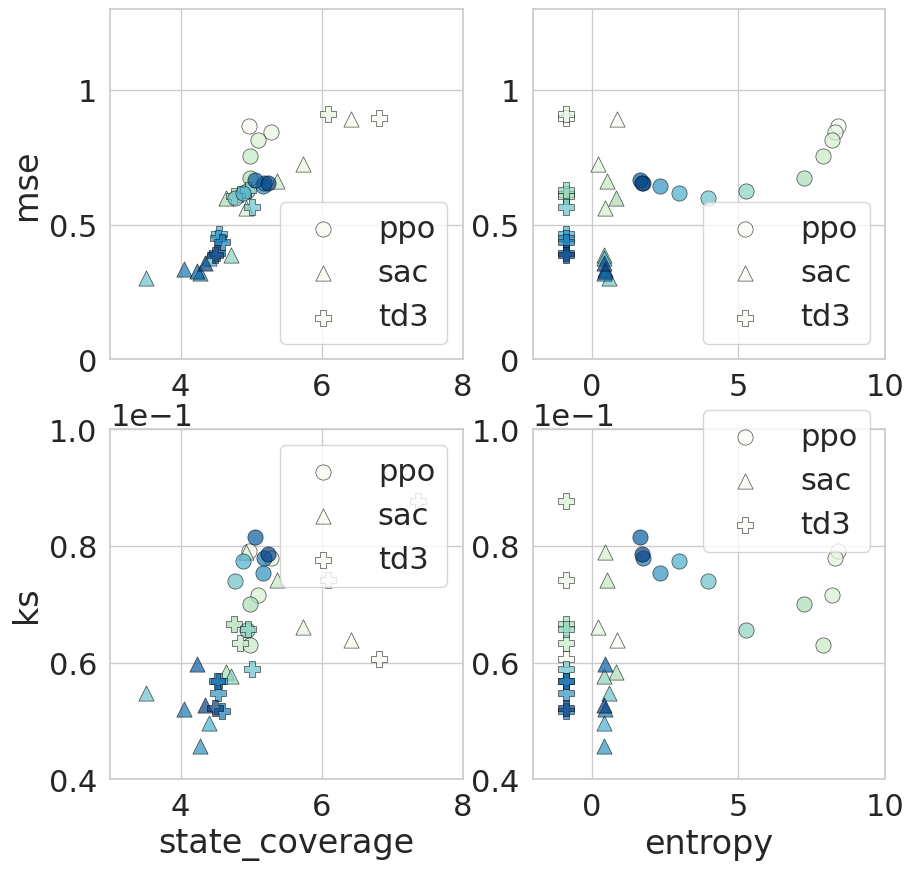

In [30]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib as mpl

def hue_style_regplot(data, x, y, hue=None, style=None, palette=None, colormap=None, **kwargs):
    regplots = []

    marker_options = ['o', '^', 'P', 'D']

    if hue is not None:
        levels = data[hue].unique()

        if palette is None:
            if colormap is None:
                colormap = 'PuOr'
            cmap = mpl.colormaps[colormap]
            colors = cmap(np.linspace(0, 1, len(levels)))
            palette = {k: colors[i] for i, k in enumerate(levels)}
    else:
        levels = [None]
        palette = {None: 'b'}  # Default color if no hue is provided

    if style is not None:
        styles = data[style].unique()
        style_map = {k: marker_options[i] for i, k in enumerate(styles)}  # Example: 'o' for even, 's' for odd
    else:
        style_map = {None: 'P'}  # Default style if no style parameter is provided

    for i, key in enumerate(levels):
        if hue is not None:
            subset = data[data[hue] == key]
        else:
            subset = data

        for style_key in styles:
            if style is not None:
                subset_style = subset[subset[style] == style_key]
            else:
                subset_style = subset

            regplots.append(
                sns.regplot(
                    x=x,
                    y=y,
                    data=subset_style,
                    color=palette[key],
                    label=f'{style_key}' if i==0 else None,
                    marker=style_map[style_key],
                    scatter_kws={'s': 120, 'edgecolors': 'black', 'linewidths': 0.5, 'alpha': 0.7},
                    line_kws={'linewidth': 3, 'alpha': 0.9},
                    **kwargs
                )
            )

    if hue is not None or style is not None:
        plt.legend()

    return regplots

def hue_style_regplot2(data, x, y, hue=None, style=None, palette=None, colormap=None, **kwargs):
    marker_options = ['o', '^', 'P', 'D']

    regplots = []

    if hue is not None:
        if data[hue].dtype.kind in 'biufc':  # Check if hue is numerical
            levels = data[hue].unique()
            if colormap is None:
                colormap = 'viridis'  # Default colormap for numerical hue
            norm = Normalize(vmin=data[hue].min(), vmax=data[hue].max())
            cmap = plt.get_cmap(colormap)
            sm = ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            palette = {k: cmap(i) for i, k in enumerate(levels)}
        else:
            levels = data[hue].unique()
            if palette is None:
                if colormap is None:
                    default_colors = plt.get_cmap('tab10')
                else:
                    default_colors = plt.get_cmap(colormap)
                palette = {k: default_colors(i) for i, k in enumerate(levels)}
    else:
        levels = [None]
        palette = {None: 'b'}  # Default color if no hue is provided

    if style is not None:
        styles = data[style].unique()
        style_map = {k: marker_options[i] for i, k in enumerate(styles)}  # Example: 'o' for even, 's' for odd
    else:
        style_map = {None: 'o'}  # Default style if no style parameter is provided

    for key in levels:
        if hue is not None and data[hue].dtype.kind in 'biufc':
            subset = data
        else:
            if hue is not None:
                subset = data[data[hue] == key]
            else:
                subset = data

        for style_key in styles:
            if style is not None:
                subset_style = subset[subset[style] == style_key]
            else:
                subset_style = subset

            scatter_kws = {'s': 120, 'edgecolors': 'black', 'linewidths': 0.5, 'alpha': 0.7}
            line_kws = {'linewidth': 3, 'alpha': 0.9}

            regplots.append(
                sns.regplot(
                    x=x,
                    y=y,
                    data=subset_style,
                    scatter_kws=scatter_kws,
                    line_kws=line_kws,
                    marker=style_map[style_key],
                    color=palette[key],
                    **kwargs
                )
            )

    if style is not None:
        plt.legend()

    if hue is not None and data[hue].dtype.kind in 'biufc':
        cbar = plt.colorbar(sm)
        cbar.set_label(hue)

    return regplots

# Example usage:
# hue_regplot(data, 'x_column', 'y_column', hue='hue_column', style='style_column', palette=None, colormap=None)
# hue_regplot(data, 'x_column', 'y_column', hue='numerical_hue_column', style='style_column', colormap='viridis')
# hue_regplot(data, 'x_column', 'y_column', style='style_column', palette=None, colormap=None)
# hue_regplot(data, 'x_column', 'y_column', palette=None, colormap=None)


sns.set_theme(style="whitegrid", font_scale=2)
sns.set_palette("colorblind")
sns.despine()
# sns.set(font_scale=2, style=)

# plt.rcParams["figure.figsize"] = [10, 10]
# plt.rcParams["figure.autolayout"] = True

colormap = 'GnBu'

plt.figure(figsize=(10,10))

ax1 = plt.subplot(2, 2, 1)
ax1.set_xlim(left=3, right=8)
ax1.set_ylim(bottom=0, top=1.3)
hue_style_regplot(
    data=df.groupby(['algo', 'policy']).mean().reset_index(), 
    x='state_coverage', 
    y='mse', 
    style='algo', 
    hue='policy',
    ci=None,
    ax=ax1,
    colormap=colormap,
)
ax1.set_xlabel(None)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%g'))
# ax1.set_xticks([])
ax2 = plt.subplot(2, 2, 2, sharey=ax1)
ax2.set_xlim(left=-2, right=10)
hue_style_regplot(
    data=df.groupby(['algo', 'policy']).mean().reset_index(), 
    x='entropy', 
    y='mse', 
    style='algo', 
    hue='policy',
    ci=None,
    ax=ax2,
    colormap=colormap,
)
ax2.set_xlabel(None)
ax2.set_ylabel(None)
# ax2.set_xticks([])
# ax2.set_yticks([])
ax3 = plt.subplot(2, 2, 3, sharex=ax1)
ax3.set_ylim(bottom=0.04, top=0.1)
hue_style_regplot(
    data=df.groupby(['algo', 'policy']).mean().reset_index(), 
    x='state_coverage', 
    y='ks', 
    style='algo', 
    hue='policy',
    ci=None,
    ax=ax3,
    colormap=colormap,
)
ax4 = plt.subplot(2, 2, 4, sharey=ax3, sharex=ax2)
hue_style_regplot(
    data=df.groupby(['algo', 'policy']).mean().reset_index(), 
    x='entropy', 
    y='ks', 
    style='algo', 
    hue='policy',
    ci=None,
    ax=ax4,
    colormap=colormap,
)
ax4.set_ylabel(None)
# ax4.set_yticks([])
plt.ticklabel_format(style='scientific', scilimits=(0,0), axis='y')
plt.legend(loc='best', bbox_to_anchor=(0.5, 0.6, 0.5, 0.5), ncols=1)
plt.savefig(f'/mnt/vdb/abenechehab/icl_paper/figures/entropy_state_coverage.pdf', bbox_inches='tight')
plt.show()

In [28]:
df.groupby(['algo', 'policy']).mean().reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   algo            36 non-null     object 
 1   policy          36 non-null     int64  
 2   Unnamed: 0      36 non-null     float64
 3   entropy         36 non-null     float64
 4   state_coverage  36 non-null     float64
 5   ks              36 non-null     float64
 6   r2              36 non-null     float64
 7   mse             36 non-null     float64
dtypes: float64(6), int64(1), object(1)
memory usage: 2.4+ KB


/tmp/ipykernel_1664986/47301213.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['algo', 'policy']).mean().reset_index().info()


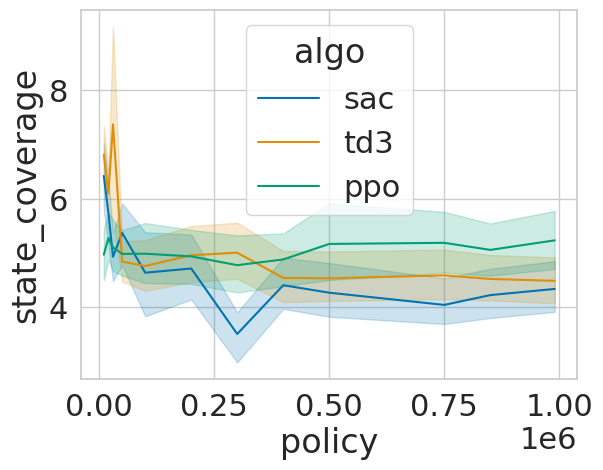

In [33]:
ax = sns.lineplot(
    data=df, 
    x='policy', 
    y='state_coverage', 
    hue='algo', 
    # style='algo'
    # col = 'dim', # creates a seperate plot for each region
    # col_wrap = 3,  # wraps columns so not all side by side
    # sharex=False, sharey=False,
    # palette='viridis',
    # ci=None
)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()
